This script creates a GIF of a choropleth map of the US showing the total number of influenza infections on a monthly basis. The data is extracted from the Influenza Research Database during the 2017-2018 season. 

Each map shows the number of both influenza A and B infections per month from the entire season, which begins in October 2017 and stops in May 2018. No cases were deposited from May to October 2018 and are not included.

In [2]:
# load required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import calendar
import os
import time

# allow plots to present within notebook
%matplotlib inline

I had a difficult time finding a shapefile that was appropriate for this project - I wanted something that represented the US with state outlines, but did not have to be technically accurate in terms of sizes or geographical characteristics (bodies of water, etc.)

Shapefiles in and of themselves are another topic entirely, and are pretty well documented, thanks to all the great cartography experts out there. I ended up going with one I found on [arcGIS](https://www.arcgis.com/home/item.html?id=f7f805eb65eb4ab787a0a3e1116ca7e5), and for the sake of simplicity, removing Alaska and Hawaii. (Leaving them in would render mainland image too small and I haven't yet figured out how to manipulate the shapefile to include them both on the shapefile itself and with the script below.) 

In [3]:
# load shapefile, remove Alaska and Hawaii

fp = "states_21basic/states.shp"
usmap_df = gpd.read_file(fp)
usmap_df = usmap_df[~usmap_df.STATE_NAME.isin(['Alaska', 'Hawaii'])]
usmap_df.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...
5,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...


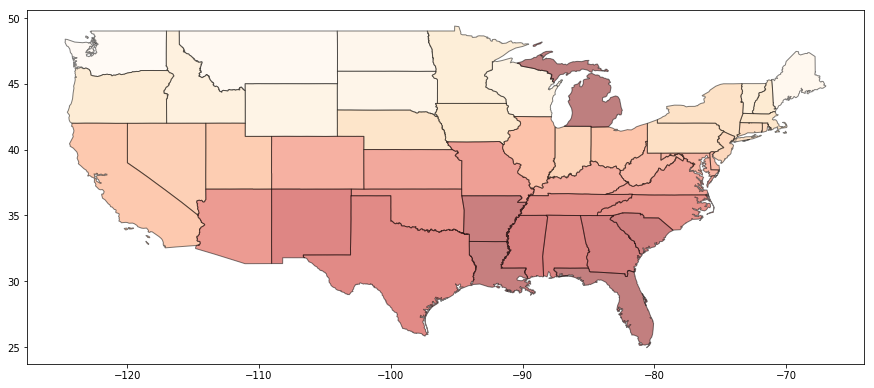

In [4]:
# view shapefile and its data

plot = usmap_df.plot(cmap='OrRd', figsize=(15,15),alpha=0.5, edgecolor='k' )            

In [5]:
# import influenza csv 

fluA_df = pd.read_csv('fluA_strains.tsv', sep='\t')
fluB_df = pd.read_csv('fluB_strains.tsv', sep='\t')

fluA_df.head(3)

,Strain Name,Complete Genome,Subtype,Collection Date,Host,Country,State/Province,Geographic Grouping,Flu Season,Submission Date,...,RERRRKKR,Sensitive Drug,Resistant Drug,Submission Date.1,NCBI Taxon ID,pH1N1-like,US Swine H1 Clade,Global Swine H1 Clade test,H5 Clade,Unnamed: 52
0,A/Alabama/01/2018,Yes,H1N1,01/02/2018,Human,USA,Alabama,North America,17-18,2018-03-24,...,No,-N/A-,-N/A-,03/24/2018,11320,Mixed Positive and Negative Segments,npdm,1A.3.3.2,-N/A-,NaN
1,A/Alabama/02/2018,Yes,H1N1,01/03/2018,Human,USA,Alabama,North America,17-18,2018-03-24,...,No,"Oseltamivir,Zanamivir",-N/A-,03/24/2018,11320,Mixed Positive and Negative Segments,npdm,1A.3.3.2,-N/A-,NaN
2,A/Alabama/03/2018,Yes,H3N2,01/03/2018,Human,USA,Alabama,North America,17-18,2018-03-24,...,No,-N/A-,-N/A-,03/24/2018,11320,Negative,-N/A-,-N/A-,-N/A-,NaN


In [6]:
# merge both fluA+fluB DataFrames into one

fluAB_df = pd.merge(fluA_df, fluB_df, how = 'outer')

fluAB_df.sample(5)

,Strain Name,Complete Genome,Subtype,Collection Date,Host,Country,State/Province,Geographic Grouping,Flu Season,Submission Date,...,Resistant Drug,Submission Date.1,NCBI Taxon ID,pH1N1-like,US Swine H1 Clade,Global Swine H1 Clade test,H5 Clade,Unnamed: 52,1 PB1,2 PB2
3048,A/swine/Iowa/A02156989/2018,No,H1N1,03/20/2018,Swine,USA,Iowa,North America,17-18,2018-04-18,...,-N/A-,04/18/2018,11320,Probable Negative,gamma,1A.3.3.3,-N/A-,NaN,NaN,NaN
4607,B/District Of Columbia/12/2018,Yes,-N/A-,03/14/2018,Human,USA,District of Columbia,North America,17-18,2018-08-13,...,-N/A-,08/13/2018,11520,-N/A-,-N/A-,-N/A-,-N/A-,NaN,MH726871,MH726870
3157,A/swine/Minnesota/A01785314/2017,No,H1N2,10/13/2017,Swine,USA,Minnesota,North America,17-18,2017-12-06,...,-N/A-,12/06/2017,2051574,Probable Negative,delta1,1B.2.2.1,-N/A-,NaN,NaN,NaN
2054,A/New Hampshire/18/2018,Yes,H3N2,03/15/2018,Human,USA,New Hampshire,North America,17-18,2018-09-18,...,-N/A-,Inconsistent,11320,Negative,-N/A-,-N/A-,-N/A-,NaN,NaN,NaN
190,A/Alberta/359/2017,No,H3N2,11/30/2017,Human,Canada,-N/A-,North America,17-18,2018-02-27,...,-N/A-,02/27/2018,11320,Probable Negative,-N/A-,-N/A-,-N/A-,NaN,NaN,NaN


In [7]:
# convert collection date to datetime obj

fluAB_df['Collection Date'] = pd.to_datetime(fluAB_df['Collection Date'])

type(fluAB_df['Collection Date'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [8]:
# apply the lambda function to the 'collection date' column and retreive the month, into 
# a new column named "month"

fluAB_df['Month'] = fluAB_df['Collection Date'].apply(lambda time: time.month)

fluAB_df['Month'].sample(5)

1598     3
4263    12
3385    10
4276    12
4492     1
Name: Month, dtype: int64

In [9]:
# convert numeral month to letter names


fluAB_df['Month'] = fluAB_df['Month'].apply(lambda x: calendar.month_name[x])

In [10]:
fluAB_df['Month'].sample(3)

2504     January
2384    December
881     December
Name: Month, dtype: object

In [11]:
#goal is to get a dataframe that lists the number of infections per month for every state.
#do a groupby sort by state and then month, and get a count of that filter.
#make a series and inject it into a new dataframe.

fluAB_byMonth_series = fluAB_df.groupby(["State/Province","Month"]).size()
# converts all NaN to zeros

fluAB_byMonth_df = pd.DataFrame(fluAB_byMonth_series)
fluAB_byMonth_df = fluAB_byMonth_df.reset_index()

fluAB_byMonth_df.sample(3)

,State/Province,Month,0
221,New Hampshire,February,11
135,Kentucky,April,2
74,Florida,December,43


In [12]:
# pivot the table so the months are columns, and the rows are states
# method chain with .fillna to get rid of all the NaN's

fluAB_fin = fluAB_byMonth_df.pivot(index='State/Province', columns='Month', values=0).fillna(0)
fluAB_fin.head(5)

Month,April,December,February,January,March,May,November,October
State/Province,,,,,,,,
-N/A-,7.0,235.0,39.0,260.0,31.0,0.0,64.0,3.0
Alabama,0.0,10.0,24.0,20.0,0.0,0.0,7.0,4.0
Alaska,10.0,15.0,14.0,9.0,15.0,9.0,22.0,11.0
Arizona,6.0,23.0,13.0,29.0,20.0,6.0,14.0,9.0
Arkansas,0.0,13.0,4.0,11.0,2.0,0.0,9.0,10.0


In [13]:
#merge the dataframes

merged = usmap_df.set_index('STATE_NAME').join(fluAB_fin)
merged.head(3)

,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry,April,December,February,January,March,May,November,October
STATE_NAME,,,,,,,,,,,,,
Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,14.0,17.0,11.0,25.0,19.0,2.0,11.0,8.0
Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,9.0,13.0,16.0,17.0,17.0,0.0,16.0,13.0
Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,13.0,5.0,15.0,12.0,14.0,0.0,1.0,0.0


In [14]:
# I'm a tidy nerd and want only the required columns and have them sorted chronologically.

merged = merged[['October', 'November', 'December', 'January', 
                 'February', 'March', 'April', 'May', 'geometry']]

merged1 = merged.rename(columns={'October':'October 2017', 'November':'November 2017', 'December':'December 2017', 
                                 'January':'January 2018', 'February':'February 2018', 'March':'March 2018', 
                                 'April':'April 2018', 'May':'May 2018'})

merged1.head(3)

,October 2017,November 2017,December 2017,January 2018,February 2018,March 2018,April 2018,May 2018,geometry
STATE_NAME,,,,,,,,,
Washington,8.0,11.0,17.0,25.0,11.0,19.0,14.0,2.0,(POLYGON ((-122.4020153103835 48.2252163723779...
Montana,13.0,16.0,13.0,17.0,16.0,17.0,9.0,0.0,POLYGON ((-111.4754253002074 44.70216236909688...
Maine,0.0,1.0,5.0,12.0,15.0,14.0,13.0,0.0,(POLYGON ((-69.77727626137293 44.0741483685119...


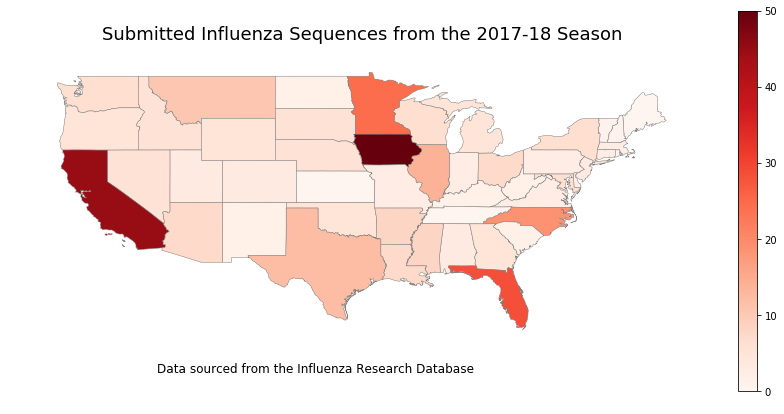

In [15]:
# let's do a test plot, and see what just October looks like

# column data from merged1 that is going to be plotted
variable = 'October 2017'

# sets the min and max values for the colorbar
vmin,vmax = 0,50

# creates a just a figure and one subplot
fig,ax = plt.subplots(1, figsize=(15,7))

# plot 
usplot = merged1.plot(column=variable, cmap='Reds', 
             linewidth=0.5, ax=ax,
           edgecolor='0.5')

# turns off the axes
ax.axis('off')

# title parameters
title = ax.set_title('Submitted Influenza Sequences from the 2017-18 Season', fontsize=18)
title.set_position([.5, 1.05])

# adds annotation at bottom of figure
ax.annotate('Data sourced from the Influenza Research Database', xy=(0.2, 0.1),
            xycoords='figure fraction',
           horizontalalignment='left',
           fontsize=12)

# adds colorbar
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm) 

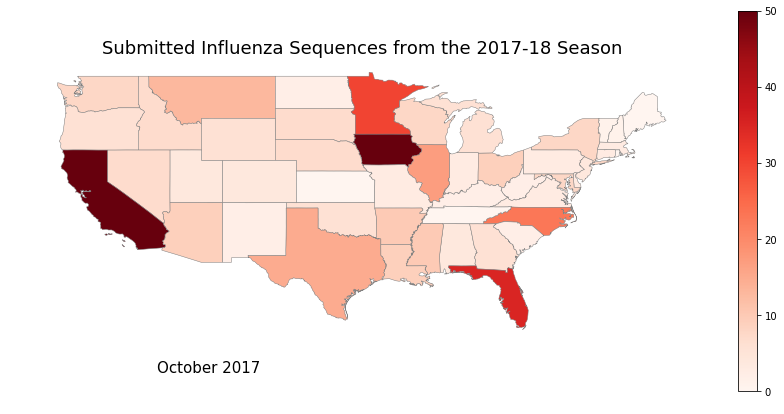

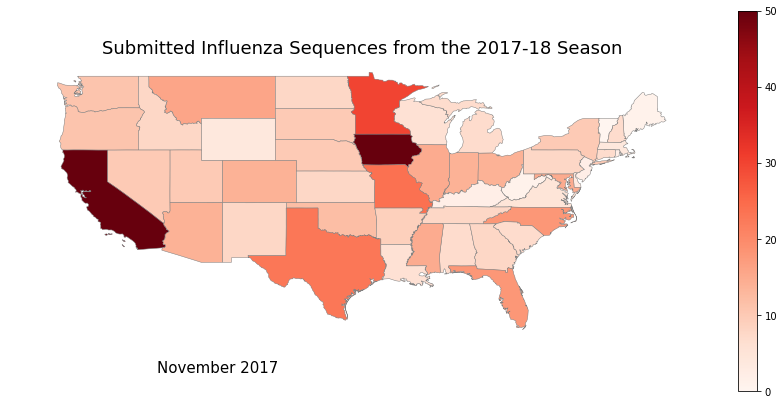

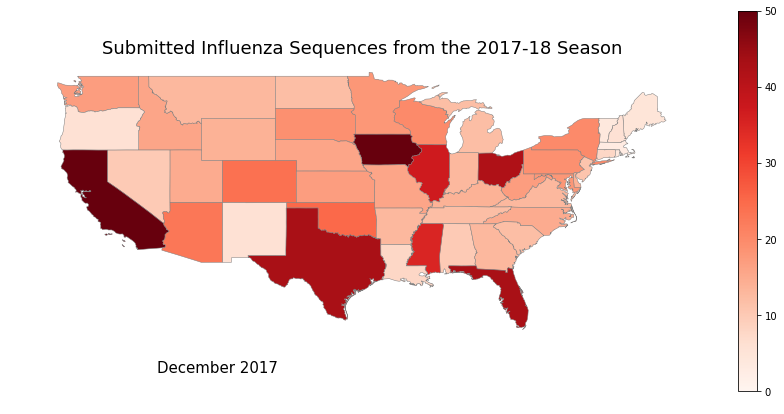

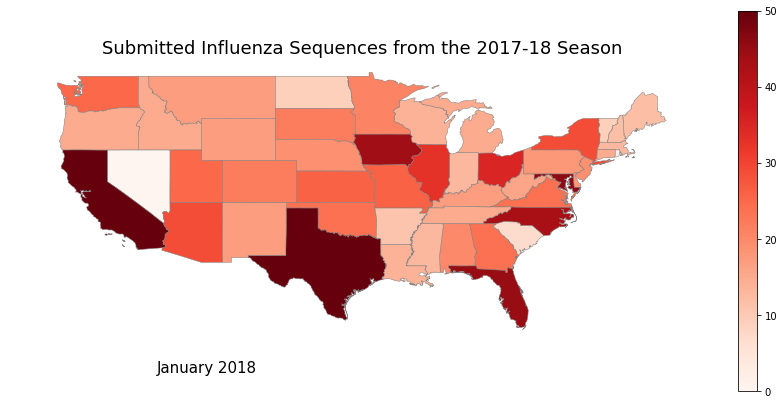

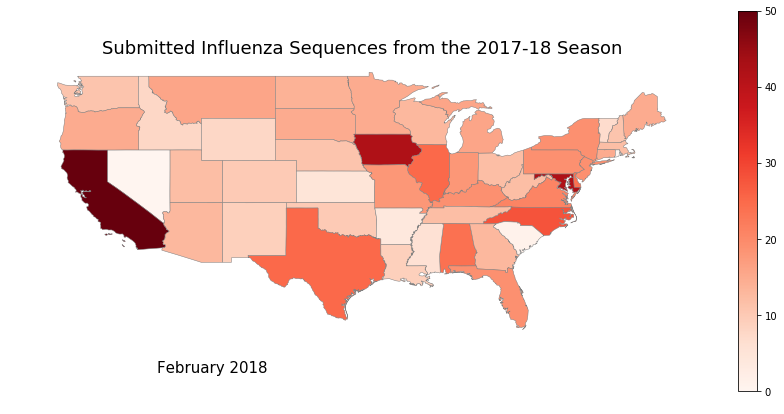

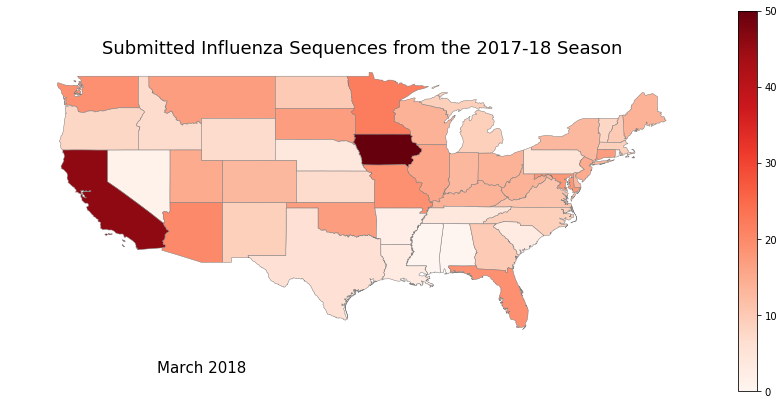

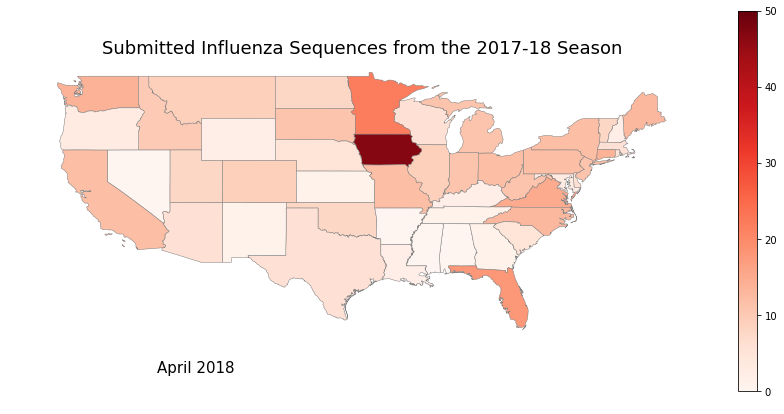

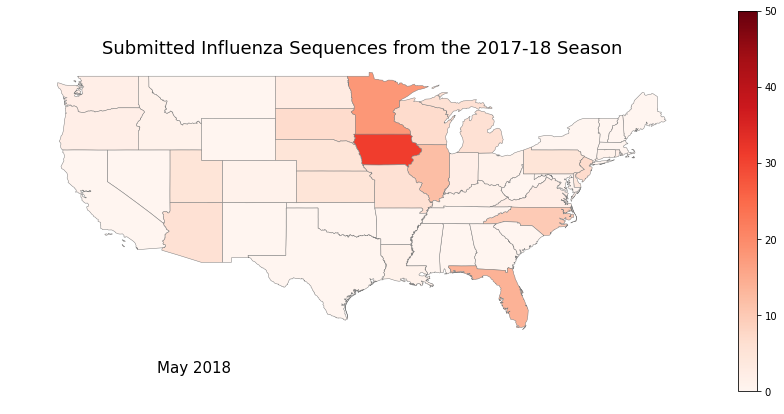

In [16]:
# This is a loop that will create a map for every month in my data named merged1
# it will then save each created map into a folder 'charts/maps'

# Where the maps will be saved
output_path = 'influenza17-18_maps'

# the columns with the values I'm presenting are named by month, so 
# put their names into a list so they can be called upon in the loop
list_o_months = ['October 2017', 'November 2017', 'December 2017', 'January 2018', 
                 'February 2018','March 2018', 'April 2018', 'May 2018']

# set the colorbar min,max values
vmin, vmax = 0,50

for month in list_o_months:
    fig = merged1.plot(column=month, cmap='Reds', figsize=(15,7), linewidth=0.5, 
                      edgecolor='0.5', vmin=vmin, vmax=vmax, legend=True,
                     norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    fig.axis('off')

    fig.set_title('Submitted Influenza Sequences from the 2017-18 Season', fontsize=18)

    fig.annotate(month, xy=(0.2, 0.1),xycoords='figure fraction',
           horizontalalignment='left', 
           fontsize=15)

# naming convention for your saved images; set the dpi - remember they add up to make a 
# single file, so not too large

    filepath = os.path.join(output_path, month+'_influenza.jpg')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=90)